In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.solvers import *

In [2]:
#Defining parameters
epsilon = 0.02
gamma = 50
M = 0.7*1e-4
maxh = 0.01 
order = 1
tau = 0.1            
T = 1

In [3]:
def FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):

    #Defining Bilinear form
    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx + mu*w*dx-epsilon*grad(phi)*grad(w)*dx
    A.Assemble()

    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []
    integral = []
    energy = []

    t=0
    while t<T:
        t+=tau
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx+gamma*(phi_old**3-phi_old)*w*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        #Computing L2 error, total mass and energy 
        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error, integral,energy

In [4]:
def IMEXScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):
    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)
    L2_error = []
    integral = []
    energy=[]
    
    t=0

    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx -gamma*(phi_old**2-1)*phi*w*dx+ mu*w*dx-epsilon*grad(phi)*grad(w)*dx
    while t<T:
        t+=tau
        A.Assemble()

        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        #Computing L2 error, total mass and energy 
        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec

    return gfut,gfu, L2_error, integral,energy

In [5]:
def FullyImplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):
    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []
    integral = []
    energy = []

    t=0
    while t<T:
        t+=tau
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)

        #Defining Bilinear form
        A = BilinearForm(fes)
        A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx -gamma*(phi**3-phi)*w*dx+ mu*w*dx-epsilon*grad(phi)*grad(w)*dx- (tau*rhs1*v*dx+ phi_old*v*dx + rhs2*w*dx)
        A.Assemble()
            

        #Solving for phi with Newton iterations
        Newton(A,gfu,freedofs=gfu.space.FreeDofs(),maxit=10,maxerr=1e-11,inverse="umfpack",dampfactor=1,printing=False)

        #Computing L2 error, total mass and energy 
        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error,integral, energy

In [6]:
def phi_exact(t):
    return t*cos(np.pi*x)*cos(np.pi*y)

def phi_dt(t):
    return cos(np.pi*x)*cos(np.pi*y)

def phi_lap(t):
    return -2*np.pi**2*phi_exact(t)

def mu_exact():
    return cos(np.pi*x)*cos(np.pi*y)

def mu_lap():
    return -2*np.pi**2*mu_exact()

In [7]:
def convergence_analysis(H,Tau,scheme,order=1):
    L2 = []
    for maxh in H:
        for tau in Tau:
            #Defining mesh and Finite element space
            mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
            V = H1(mesh, order=order) 
            fes = V*V 

            #Defining trial and test functions
            phi,mu = fes.TrialFunction() 
            v,w = fes.TestFunction()

            #Initialising phi_0 
            phi_old = GridFunction(V)
            initial_values = np.zeros(V.ndof)
            phi_old.vec.data = initial_values

            gfut,gfu,L2_error,integral,energy = scheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T)
            L2.append([tau, maxh, max(L2_error)])
            df = pd.DataFrame(L2, columns=["tau", "maxh", "L2_error"])
    return df, integral, energy

In [20]:

H = np.array([0.4,0.2,0.1,0.05,0.025])
Tau = H**2*0.2

#Explicit_df= convergence_analysis(H,Tau,FullyExplicitScheme)[0]
IMEX_df, IMEX_integral, IMEX_energy = convergence_analysis(H,Tau,IMEXScheme)
#Implicit_df, Implicit_integral,Implicit_energy = convergence_analysis(H,Tau,FullyImplicitScheme)

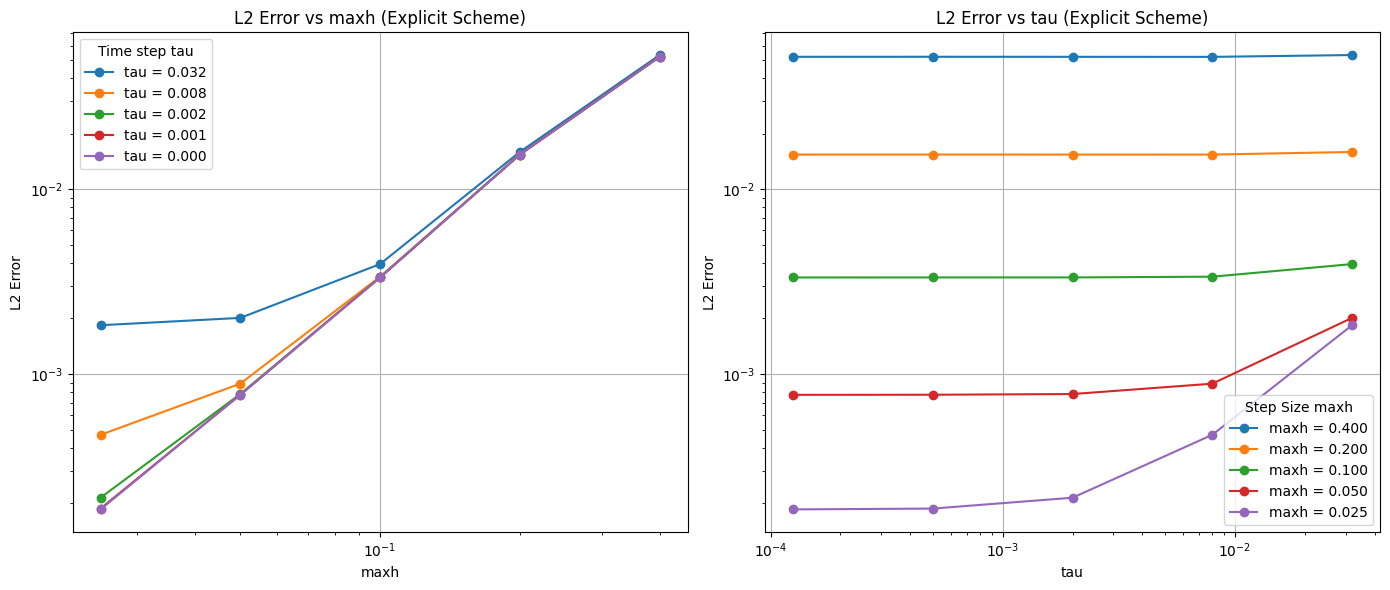

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for tau in Explicit_df['tau'].unique():
    df_tau = Explicit_df[Explicit_df['tau'] == tau]
    axs[0].loglog(df_tau['maxh'], df_tau['L2_error'], marker='o', label=f'tau = {tau:.3f}')
axs[0].set_xlabel('maxh')
axs[0].set_ylabel('L2 Error')
axs[0].set_title('L2 Error vs maxh (Explicit Scheme)')
axs[0].legend(title="Time step tau")
axs[0].grid(True)

for maxh in Explicit_df['maxh'].unique():
    df_tau = Explicit_df[Explicit_df['maxh'] == maxh]
    axs[1].loglog(df_tau['tau'], df_tau['L2_error'], marker='o', label=f'maxh = {maxh:.3f}')
axs[1].set_xlabel('tau')
axs[1].set_ylabel('L2 Error')
axs[1].set_title('L2 Error vs tau (Explicit Scheme)')
axs[1].legend(title="Step Size maxh")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [15]:
Explicit_df

,tau,maxh,L2_error
0,0.160000,0.400,0.058637
1,0.040000,0.400,0.052026
2,0.010000,0.400,0.052135
3,0.002500,0.400,0.052307
4,0.000625,0.400,0.052215
5,0.160000,0.200,0.022526
6,0.040000,0.200,0.015620
7,0.010000,0.200,0.015429
8,0.002500,0.200,0.015462
9,0.000625,0.200,0.015433


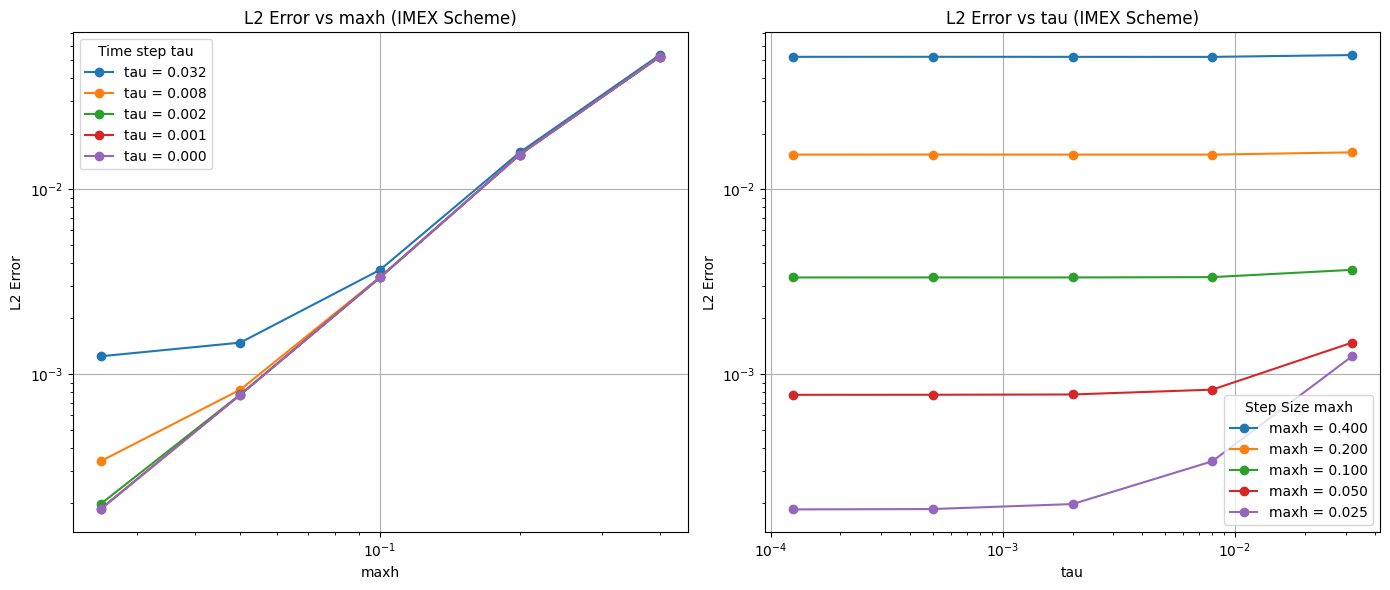

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for tau in IMEX_df['tau'].unique():
    df_tau = IMEX_df[IMEX_df['tau'] == tau]
    axs[0].loglog(df_tau['maxh'], df_tau['L2_error'], marker='o', label=f'tau = {tau:.3f}')
axs[0].set_xlabel('maxh')
axs[0].set_ylabel('L2 Error')
axs[0].set_title('L2 Error vs maxh (IMEX Scheme)')
axs[0].legend(title="Time step tau")
axs[0].grid(True)

for maxh in IMEX_df['maxh'].unique():
    df_tau = IMEX_df[IMEX_df['maxh'] == maxh]
    axs[1].loglog(df_tau['tau'], df_tau['L2_error'], marker='o', label=f'maxh = {maxh:.3f}')
axs[1].set_xlabel('tau')
axs[1].set_ylabel('L2 Error')
axs[1].set_title('L2 Error vs tau (IMEX Scheme)')
axs[1].legend(title="Step Size maxh")
axs[1].grid(True)

plt.tight_layout()
plt.show()


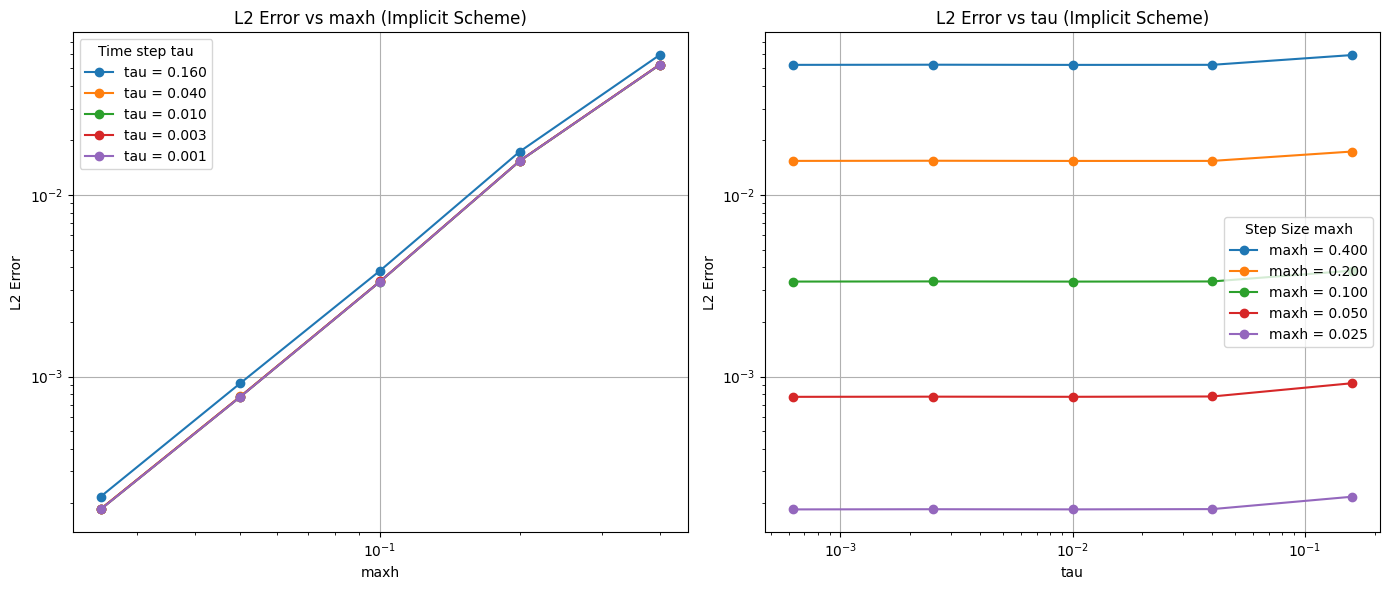

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for tau in Implicit_df['tau'].unique():
    df_tau = Implicit_df[Implicit_df['tau'] == tau]
    axs[0].loglog(df_tau['maxh'], df_tau['L2_error'], marker='o', label=f'tau = {tau:.3f}')
axs[0].set_xlabel('maxh')
axs[0].set_ylabel('L2 Error')
axs[0].set_title('L2 Error vs maxh (Implicit Scheme)')
axs[0].legend(title="Time step tau")
axs[0].grid(True)

for maxh in Implicit_df['maxh'].unique():
    df_tau = Implicit_df[Implicit_df['maxh'] == maxh]
    axs[1].loglog(df_tau['tau'], df_tau['L2_error'], marker='o', label=f'maxh = {maxh:.3f}')
axs[1].set_xlabel('tau')
axs[1].set_ylabel('L2 Error')
axs[1].set_title('L2 Error vs tau (Implicit Scheme)')
axs[1].legend(title="Step Size maxh")
axs[1].grid(True)

plt.tight_layout()
plt.show()
